In [1]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

sim_name = f"SunMod_1k"
sim_folder = f"sim_output/{sim_name}"

fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)

# Solar Gravity implementation

## Sun gravity function

In [ ]:
# Compute gradient of sun.
init_dis = 1*Params.AU
x_i = np.array([init_dis, 0., 0.])
eps = 696_340*Params.km  # solar radius in numerical units
grad_sun = SimExec.sun_gravity(x_i, eps, jnp.array([0,0,0]))
ic(grad_sun)

# Solar acceleration, should be around ~6 millimeter/s^2 according to internet
grad_sun /= (Params.m/1e3/Params.s**2)
ic(grad_sun)

In [ ]:
z_int_steps = jnp.load(f'{sim_folder}/z_int_steps_1year.npy')
s_int_steps = jnp.load(f'{sim_folder}/s_int_steps_1year.npy')
z_test = 0.
idx = jnp.abs(z_int_steps - z_test).argmin()

# Load gravity 
halo_ID = 53
data_dir = f"Data/halo_grids"
dPsi_grids, cell_grids, cell_gens = SimGrid.grid_data(halo_ID, data_dir)
snaps_GRID_L = jnp.load(f'{data_dir}/snaps_GRID_L_halo1.npy')

dPsi_grid = dPsi_grids[idx]
cell_grid = cell_grids[idx]
cell_gens = cell_gens[idx]
snap_GRID_L = snaps_GRID_L[idx]

x_i = jnp.array([8.1, 0., 0.])*Params.kpc
cell_idx, *_ = SimExec.nu_in_which_cell(
    x_i, cell_grid, cell_gens, snap_GRID_L)
grad_tot = dPsi_grid[cell_idx, :]
ic(grad_tot)
print("...")

# Solar dipole implementation

## Planck (2018) values

In [ ]:
v_Sun_CMB = 369.82*Params.km/Params.s  # velocity of Sun w.r.t. CMB
l_Sun_CMB = 264.021
b_Sun_CMB = 48.253

vec_Sun_CNB = SimUtil.Galactic_velocity_to_Cartesian_vector(
    v_Sun_CMB, l_Sun_CMB, b_Sun_CMB)/(Params.km/Params.s)

mag_Sun_CNB = jnp.linalg.norm(vec_Sun_CNB)

ic(vec_Sun_CNB)
ic(mag_Sun_CNB)
ic(vec_Sun_CNB/mag_Sun_CNB)
print("...")

## Dipole maps for each day of the year: Earth's frame

In [16]:
def calculate_sun_and_earth_position_and_velocity(year):
    # Define the Galactic Center coordinates
    gc = SkyCoord(l=0*apu.degree, b=0*apu.degree, frame='galactic')
    
    # Sun's velocity w.r.t. CMB in galactic coordinates (km/s)
    sun_vel_cmb_gal = np.array([-0.06935679, -0.66222051, 0.74609224]) * 369.82
    
    # Create lists to store the Sun's positions and velocities, and Earth's velocities
    sun_positions = []
    sun_velocities_cmb = []
    earth_velocities_cmb = []
    
    for day in range(365, 0, -1):  # Loop backwards through each day of the year
        # Create Time objects for the current day and the next day at noon UTC
        time = Time(f'{year}-12-31 12:00:00') - (365 - day) * apu.day
        time_next = time + 1 * apu.day
        
        # Get the Earth's position in ICRS coordinates at current and next day (in km)
        earth_icrs = SkyCoord(get_body_barycentric('earth', time), frame='icrs')
        earth_icrs_next = SkyCoord(get_body_barycentric('earth', time_next), frame='icrs')
        
        # Calculate Earth's velocity in ICRS frame (km/s)
        earth_vel_icrs = (earth_icrs_next.cartesian.xyz - earth_icrs.cartesian.xyz).to(apu.km).value / apu.day.to(apu.s)
        
        # Get the Sun's position in GCRS coordinates (relative to Earth) in km
        sun_gcrs = SkyCoord(get_body_barycentric('sun', time), frame='icrs').transform_to(GCRS(obstime=time))
        sun_vector = sun_gcrs.cartesian.xyz.to(apu.km).value
        
        # Transform the Galactic Center to GCRS
        gc_gcrs = gc.transform_to(GCRS(obstime=time))
        
        # Calculate the unit vector pointing from Earth to Galactic Center
        gc_vector = gc_gcrs.cartesian.xyz.value
        gc_unit_vector = gc_vector / np.linalg.norm(gc_vector)
        
        # Define the new coordinate system
        x_axis = gc_unit_vector
        z_axis = np.cross(x_axis, [0, 0, 1])
        z_axis = z_axis / np.linalg.norm(z_axis)
        y_axis = np.cross(z_axis, x_axis)
        
        # Create the rotation matrix
        rotation_matrix = np.column_stack((x_axis, y_axis, z_axis))
        
        # Rotate the Sun's position into the new coordinate system (km)
        sun_rotated = np.dot(rotation_matrix.T, sun_vector)
        
        # Rotate the Sun's velocity w.r.t. CMB into the new coordinate system (km/s)
        sun_vel_cmb_rotated = np.dot(rotation_matrix.T, sun_vel_cmb_gal)
        
        # Rotate Earth's velocity into the new coordinate system (km/s)
        earth_vel_rotated = np.dot(rotation_matrix.T, earth_vel_icrs)
        
        # Calculate Earth's velocity relative to CMB in the rotated frame (km/s)
        earth_vel_cmb_rotated = sun_vel_cmb_rotated + earth_vel_rotated
        
        # Append the rotated position and velocities to the lists
        sun_positions.append(sun_rotated)
        sun_velocities_cmb.append(sun_vel_cmb_rotated)
        earth_velocities_cmb.append(earth_vel_cmb_rotated)
    
    # note: sun_positions: km units ; velocities: km/s units
    return np.array(sun_positions), np.array(sun_velocities_cmb), np.array(earth_velocities_cmb)


def create_dipole_map(velocity_vector, simdata, args):
    
    # Get the theta and phi angles for each pixel
    theta, phi = hp.pix2ang(simdata.Nside, np.arange(simdata.Npix))
    
    # Convert velocity vector to spherical coordinates
    v_mag = np.linalg.norm(velocity_vector)
    v_theta = np.arccos(velocity_vector[2] / v_mag)
    v_phi = np.arctan2(velocity_vector[1], velocity_vector[0])
    
    # Calculate the dipole anisotropy
    cos_angle = np.sin(theta) * np.sin(v_theta) * np.cos(phi - v_phi) + np.cos(theta) * np.cos(v_theta)
    dipole = args.T_CNB * (1 + v_mag * cos_angle)
    
    return dipole


def create_neutrino_density_dipole_animation(year, simdata, Params, sim_folder, fps=2, dpi=100, day_step=5):
    # Get Sun and Earth velocities
    sun_positions, sun_velocities_cmb, earth_velocities_cmb = calculate_sun_and_earth_position_and_velocity(year)

    # Earth velocities in Earth-GC frame
    earth_vels = earth_velocities_cmb - sun_velocities_cmb

    # Convert velocities to km/s
    sun_velocities_cmb *= Params.km/Params.s
    earth_velocities_cmb *= Params.km/Params.s

    nu_ratios_l = []
    frames = []

    for day in range(1, 366, day_step):
        earth_vel_cmb = earth_velocities_cmb[day-1]
        
        # Compute temperature dipole map from combined velocity vector
        T_dipole_map = create_dipole_map(earth_vel_cmb, simdata, Params)

        # Convert to number density map
        N_dipole_map = 3*zeta(3) / (4*Params.Pi**2) * T_dipole_map**3

        # Get increase/decrease factor, i.e. ratio compared to LambdaCDM value
        nu_ratio = N_dipole_map/Params.N0
        nu_ratios_l.append(nu_ratio)

        # Create a new figure for each day
        fig = plt.figure(figsize=(12, 8))
        hp.mollview(
            nu_ratio, 
            title=f"Neutrino Density Dipole - Day {day}", 
            unit=r"$n_\nu / n_{\nu,0}$", 
            cmap="coolwarm",
            fig=fig
        )
        hp.graticule()

        # Save the figure to a buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=dpi)
        buf.seek(0)
        
        # Read the image and append to frames
        img = plt.imread(buf)
        frames.append(img)
        
        plt.close(fig)

    # Create the animation
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')
    im = ax.imshow(frames[0])

    def animate(i):
        im.set_array(frames[i])
        return [im]

    anim = FuncAnimation(fig, animate, frames=len(frames), interval=1000//fps, blit=True)

    # Save the animation
    anim.save(f"{sim_folder}/nu_density_dipole_animation.gif", writer='pillow', fps=fps)

    # Save the nu_ratios_l array
    jnp.save(f"{sim_folder}/nu_dens_dipole_factors.npy", jnp.array(nu_ratios_l))

    plt.close(fig)


# Usage
year = 2024
create_neutrino_density_dipole_animation(year, simdata, Params, sim_folder, fps=4, dpi=100, day_step=5)

# Integration steps: z, s and t

In [ ]:
def z_at_age(age):
    
    # Function to calculate redshift for a given age of the universe
    def age_diff(z):
        return cosmo.age(z).to(apu.year).value - age
    
    # Use root_scalar to find the redshift that gives the specified age
    sol = root_scalar(
        age_diff, bracket=[0, 10], method='brentq', xtol=1e-12, rtol=1e-12)
    return sol.root


def get_redshift_array(days):

    # Today's date
    today = Time.now()
    
    # Calculate redshift for each day
    redshifts = jnp.zeros(days)
    age_today = cosmo.age(0).to(apu.year).value  # Age of the universe today
    for day in range(days):

        # Calculate the date for each day of the past year
        past_date = today - day*apu.day
        
        # Calculate the lookback time in years
        lookback_time = (today - past_date).to(apu.year).value
        
        # Calculate the age of the universe at this lookback time
        age_of_universe_then = age_today - lookback_time
        
        # Find the redshift corresponding to this age of the universe
        redshift = z_at_age(age_of_universe_then)
        
        # Store the redshift value in the array
        redshifts = redshifts.at[day].set(redshift)
    
    return redshifts


def s_of_z(z, args):
    """
    Convert redshift to time variable s with eqn. 4.1 in Mertsch et al.
    (2020), keeping only Omega_M and Omega_L in the Hubble eqn. for H(z).

    Args:
        z (float): redshift

    Returns:
        float: time variable s (in [seconds] if 1/H0 factor is included)
    """    

    def s_integrand(z):        

        # We need value of H0 in units of 1/s.
        H0_val = args.H0/(1/args.s)
        a_dot = np.sqrt(args.Omega_M*(1.+z)**3 + args.Omega_L)/(1.+z)*H0_val
        s_int = 1./a_dot

        return s_int

    s_of_z, _ = quad(s_integrand, 0., z)

    return jnp.float64(s_of_z)


# Function to generate t_int_steps using Astropy
def generate_t_int_steps(z_int_steps):
    # Convert z_int_steps to a numpy array if it's not already
    z_int_steps_np = np.array(z_int_steps)
    
    # Calculate lookback times using Astropy
    t_int_steps_astropy = cosmo.lookback_time(z_int_steps_np)
    
    # Convert to seconds and then to a JAX array
    t_int_steps = jnp.array(t_int_steps_astropy.to(apu.s).value)
    
    return t_int_steps


# 2 years plus additional day, s.t. integration routine can pick 2nd last
# (see notes in backtrack_1_neutrino function)
days = (365*2)+1

# Get the redshift array for these (past) days
z_int_steps_2years = get_redshift_array(days)

# Convert to integration variable s
s_int_steps_2years = jnp.array(
    [s_of_z(z, Params()) for z in z_int_steps_2years])

# Convert to "physical" time in seconds
t_int_steps_2years = generate_t_int_steps(z_int_steps_2years)

jnp.save(f"{sim_folder}/z_int_steps_2years.npy", z_int_steps_2years)
jnp.save(f"{sim_folder}/s_int_steps_2years.npy", s_int_steps_2years)
jnp.save(f"{sim_folder}/t_int_steps_2years.npy", t_int_steps_2years)

# PSD interpolation

In [ ]:
def CNB_to_Earth_frame_trafo(u, v):
    """
    Transform velocity from CNB frame (S) to Earth frame (S') using relativistic velocity addition formula.
    
    Parameters:
    u: velocity of object (neutrinos) in frame S
    v: velocity of frame S' as measured in frame S
    
    Returns:
    u_prime: velocity of object in frame S'
    """
    c_unit = Params.c/(Params.kpc/Params.s)  # c in our velocity units
    
    u_dot_v = jnp.sum(u*v, axis=-1, keepdims=True)
    v_sq = jnp.sum(v**2, axis=-1, keepdims=True)
    
    # Lorentz factor
    gamma = 1/jnp.sqrt(1 - v_sq/c_unit**2)
    
    numer = u/gamma - v + (gamma/(c_unit**2*(1+gamma)))*u_dot_v*v
    denom = 1 - u_dot_v/c_unit**2
    u_prime = numer/denom
    
    return u_prime


# List to store number densities for each day
days_nrs_l = []
n_nu_days_l = []

# Get Earth velocities w.r.t. the CNB 
# note: This includes ("inherited") solar system motion
_, _, earth_vels_CNB = SimPlot.SunEarthGC_frame_coords(2024)
earth_vels_CNB *= (Params.km/Params.s)/(Params.kpc/Params.s)


### ================== ###
### DM halo simulation ###
### ================== ###

# Neutrino velocities
halo_num = 6
vels = SimData.load_velocities(sim_dir=sim_folder, halo_num=halo_num)

# Convert velocities to momenta
p_arr, y_arr = Physics.velocities_to_momenta_ND_halo_0th_axis(
    v_arr=vels, 
    m_arr=nu_m_picks,
    args=Params())

p_z0 = p_arr[...,0]
p_z4 = p_arr[...,-1]
y_z0 = y_arr[...,0]

# Sort in ascending order of momentum array today
ind = p_z0.argsort(axis=-1)
p_z0_sort = jnp.take_along_axis(p_z0, ind, axis=-1)
p_z4_sort = jnp.take_along_axis(p_z4, ind, axis=-1)
y_z0_sort = jnp.take_along_axis(y_z0, ind, axis=-1)
# note: z0 sorted arrays of days and DM-sim match (i.e are equivalent)

# PSD of z0 using Fermi-Dirac assumption and Liouville's theorem
FD_vals_z0 = Physics.Fermi_Dirac(p_z4_sort, Params())
# (halos, masses, Npix, p_num)


for day in range(0, 365, 12):

    ### ==================== ###
    ### Solar modulation sim ###
    ### ==================== ###

    # Load velocities for current day
    # Insert dimension at beginning to account for multiple halos later
    file_path = f"{sim_folder}/vectors_day{day+1}.npy"

    if os.path.exists(file_path):
        day_vels = jnp.load(file_path)[..., 3:][None, ...]
        print(f"Day {day+1}/365")
        days_nrs_l.append(day+1)
        
        #! Velocities from CNB frame (used in simulations) to Earth frame
        day_vels = CNB_to_Earth_frame_trafo(day_vels, earth_vels_CNB[day])

        # Convert to momentum arrays (p and y)
        p_day, y_day = Physics.velocities_to_momenta_ND_halo_0th_axis(
            v_arr=day_vels,
            m_arr=nu_m_picks,
            args=Params())

        p_day_z0 = p_day[...,0]
        p_day_z4 = p_day[...,-1]
        y_day_z0 = y_day[...,0]
        y_day_z4 = y_day[...,-1]

        # Sort in ascending order of momentum array today
        ind = p_day_z0.argsort(axis=-1)
        p_day_z0_sort = jnp.take_along_axis(p_day_z0, ind, axis=-1)
        p_day_z4_sort = jnp.take_along_axis(p_day_z4, ind, axis=-1)
        y_day_z0_sort = jnp.take_along_axis(y_day_z0, ind, axis=-1)
        y_day_z4_sort = jnp.take_along_axis(y_day_z4, ind, axis=-1)

        @jax.jit
        def compute_PSDs_day(y_day_z4_sort, y_z0_sort, FD_vals_z0):
            # Vectorize the interpolation across all dimensions
            PSDs_day = Utils.vectorized_interpolate_1D(
                y_day_z4_sort, y_z0_sort, FD_vals_z0)
            return PSDs_day

        # PSDs_day = compute_PSDs_day(
        #     jnp.repeat(y_day_z4_sort, len(y_z0_sort), axis=0), y_z0_sort, FD_vals_z0)

        # note: Fermi-Dirac Phase-space, for testing
        PSDs_day = Physics.Fermi_Dirac(p_day_z4_sort, Params())


        ### ================================= ###
        ### Compute number densities for days ###
        ### ================================= ###

        #? some values are above 0.5, some interpolation issue at the edges?
        PSDs_day = jnp.clip(PSDs_day, a_min=None, a_max=0.5)

        # Integrand in number density expression
        y = p_day_z0_sort**3 * PSDs_day  # dlog integrand
        x = p_day_z0_sort
        n_raw = trap(y, jnp.log(x), axis=-1)

        # Multiply by constants and/or solid angles and convert to 1/cm**3.
        pix_sr = 4*Params.Pi/simdata.Npix
        n_cm3 = pix_sr * Params.g_nu/((2*Params.Pi)**3) * n_raw / (1/Params.cm**3)
        n_cm3_pix = jnp.array(n_cm3)
        n_tot = jnp.sum(n_cm3_pix, axis=-1)

        n_nu_days_l.append(n_tot)
    else:
        pass


# For simulation PSDs
# jnp.save(f"{sim_folder}/n_nu_days_Earth_frame.npy", jnp.array(n_nu_days_l))
# jnp.save(f"{sim_folder}/days_nrs_Earth_frame.npy", jnp.array(days_nrs_l))

# For FD PSD (for testing and comparing)
jnp.save(f"{sim_folder}/n_nu_days_Earth_frame_FD.npy", jnp.array(n_nu_days_l))
jnp.save(f"{sim_folder}/days_nrs_Earth_frame_FD.npy", jnp.array(days_nrs_l))

# Analysis

## Method for computing Earth's positions and velocities

### Method functions

In [2]:
def calculate_fractional_day_numbers(year):
    """
    Calculate the fractional day number n for each day of the given year.
    
    :param year: The year for which to calculate the fractional day numbers
    :return: A list of tuples, each containing (date, fractional day number)
    """
    results = []
    start_date = datetime(year, 1, 1)
    
    for day in range(
        366 if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0) else 365):
        current_date = start_date + timedelta(days=day)
        Y, M, D = current_date.year, current_date.month, current_date.day
        
        Y_tilde = Y - 1 if M <= 2 else Y
        M_tilde = M + 12 if M <= 2 else M
        
        n = np.floor(365.25 * Y_tilde) + np.floor(30.61 * (M_tilde + 1)) + D - 730563.5
        
        results.append((current_date.strftime('%Y-%m-%d'), n))
    
    return results


def calculate_average_ecliptic_vectors(year):
    """
    Calculate the average ecliptic unit vectors ϵ_x and ϵ_y for the given year.
    
    :param year: The year for which to calculate the average ecliptic vectors
    :return: A tuple containing (year, average ϵ_x, average ϵ_y)
    """
    # Constants for ϵ_x and ϵ_y calculations
    eps_x_0 = np.array([0.054876, -0.494109, 0.867666])
    eps_x_T = np.array([-0.024232, -0.002689, 1.546e-6])
    eps_y_0 = np.array([0.993821, 0.110992, 0.000352])
    eps_y_T = np.array([0.001316, -0.011851, 0.021267])
    
    eps_x_sum = np.zeros(3)
    eps_y_sum = np.zeros(3)
    
    # Get fractional day numbers for the year
    fractional_days = calculate_fractional_day_numbers(year)
    
    for _, n in fractional_days:
        # Calculate T
        T = n / 36525
        
        # Calculate ϵ_x and ϵ_y for this day
        eps_x = eps_x_0 + eps_x_T * T
        eps_y = eps_y_0 + eps_y_T * T
        
        # Add to the sum
        eps_x_sum += eps_x
        eps_y_sum += eps_y
    
    # Calculate averages
    days_in_year = len(fractional_days)
    eps_x_avg = eps_x_sum / days_in_year
    eps_y_avg = eps_y_sum / days_in_year
    
    # Normalize the average vectors
    eps_x_avg /= np.linalg.norm(eps_x_avg)
    eps_y_avg /= np.linalg.norm(eps_y_avg)
    
    return eps_x_avg, eps_y_avg


def calculate_earth_position(year):
    """
    Calculate Earth's position relative to the Sun in ecliptic coordinates for each day of the year.
    
    :param year: The year for which to calculate Earth's position
    :return: A list of tuples, each containing (date, position vector)
    """
    # Constants
    e = 0.9574  # eccentricity in degrees
    e_rad = np.radians(e)

    # Get fractional day numbers and ecliptic vectors for the year
    fractional_days = calculate_fractional_day_numbers(year)
    eps_x, eps_y = calculate_average_ecliptic_vectors(year)

    results = []

    for date, n in fractional_days:
        # Calculate L, g, and varpi
        L = np.radians(280.460 + 0.9856474 * n)
        g = np.radians(357.528 + 0.9856003 * n)
        varpi = np.radians(282.932 + 0.0000471 * n)

        # Calculate ecliptic longitude
        l = L + 2 * e_rad * np.sin(g) + 5/4 * e_rad**2 * np.sin(2*g)

        # Calculate Earth-Sun distance (in AU)
        r = 1.00014 - 0.01671 * np.cos(g) - 0.00014 * np.cos(2*g)

        # Calculate position vector
        position = r * (np.cos(l) * eps_x + np.sin(l) * eps_y)

        results.append((date, position))

    return results


def calculate_earth_velocity(year):
    """
    Calculate Earth's velocity for each day of the year.
    
    :param year: The year for which to calculate Earth's velocity
    :return: A list of tuples, each containing (date, velocity vector)
    """
    # Constants
    e = 0.9574  # eccentricity in degrees
    e_rad = np.radians(e)
    u_E_avg = 29.79  # Average Earth velocity in km/s

    # Get fractional day numbers and ecliptic vectors for the year
    fractional_days = calculate_fractional_day_numbers(year)
    eps_x, eps_y = calculate_average_ecliptic_vectors(year)

    results = []

    for date, n in fractional_days:
        # Calculate L and varpi
        L = np.radians(280.460 + 0.9856474 * n)
        varpi = np.radians(282.932 + 0.0000471 * n)

        # Calculate velocity components
        v_x = -u_E_avg * (np.sin(L) + e_rad * np.sin(2*L - varpi))
        v_y = u_E_avg * (np.cos(L) + e_rad * np.cos(2*L - varpi))

        # Calculate velocity vector
        velocity = v_x * eps_x + v_y * eps_y

        results.append((date, velocity))

    return results


### =========== ###
### Computing n ###
### =========== ###

year = 2023
fractional_days = calculate_fractional_day_numbers(year)
print(f"{len(fractional_days)} days for year {year}")

# Verify the example given (31st January 2009)
verification_date = datetime(2009, 1, 31)
Y, M, D = verification_date.year, verification_date.month, verification_date.day
Y_tilde = Y - 1 if M <= 2 else Y
M_tilde = M + 12 if M <= 2 else M
n_verification = np.floor(365.25 * Y_tilde) + np.floor(30.61 * (M_tilde + 1)) + D - 730563.5
print(f"\nVerification for 31st January 2009:")
print(f"Calculated n: {n_verification}")
print(f"Expected n: 3318.25 (at 6 p.m. GMT, our result is for 0:00 AM GMT)")


### ================ ###
### Ecliptic vectors ###
### ================ ###

eps_vectors = calculate_average_ecliptic_vectors(year)

print(f"Average ecliptic unit vectors for {year}:")
print(f"  ϵ_x = {eps_vectors[0]}")
print(f"  ϵ_y = {eps_vectors[1]}")

# Verify that the vectors are unit vectors
eps_x_magnitude = np.linalg.norm(eps_vectors[0])
eps_y_magnitude = np.linalg.norm(eps_vectors[1])
print(f"\nVerification:")
print(f"Magnitude of average ϵ_x: {eps_x_magnitude:.10f}")
print(f"Magnitude of average ϵ_y: {eps_y_magnitude:.10f}")

# Check orthogonality
dot_product = np.dot(eps_vectors[0], eps_vectors[1])
print(f"Dot product of ϵ_x and ϵ_y: {dot_product:.10f}")


### =============== ###
### Earth positions ###
### =============== ###

earth_positions = calculate_earth_position(year)

# Verify the magnitude of the position vector (should be close to 1 AU)
first_day = earth_positions[0]
position_magnitude = np.linalg.norm(first_day[1])
print(f"\nVerification for {first_day[0]}:")
print(f"Magnitude of position vector: {position_magnitude:.10f} AU")

365 days for year 2023

Verification for 31st January 2009:
Calculated n: 3317.5
Expected n: 3318.25 (at 6 p.m. GMT, our result is for 0:00 AM GMT)
Average ecliptic unit vectors for 2023:
  ϵ_x = [ 0.04918127 -0.49473286  0.86765235]
  ϵ_y = [0.99411415 0.10820555 0.00534915]

Verification:
Magnitude of average ϵ_x: 1.0000000000
Magnitude of average ϵ_y: 1.0000000000
Dot product of ϵ_x and ϵ_y: 0.0000001537

Verification for 2023-01-01:
Magnitude of position vector: 0.9833126525 AU


### Plots and comparisons

In [ ]:
def plot_earth_trajectory_3d(year):
    earth_positions = calculate_earth_position(year)
    
    # Extract x, y, and z coordinates
    x = [pos[0] for _, pos in earth_positions]
    y = [pos[1] for _, pos in earth_positions]
    z = [pos[2] for _, pos in earth_positions]
    
    # Calculate distances from Sun
    distances = [np.linalg.norm(pos) for _, pos in earth_positions]
    
    # Find min and max distances
    min_dist_index = np.argmin(distances)
    max_dist_index = np.argmax(distances)
    
    # Create the 3D plot
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the orbit
    ax.plot(x, y, z, label='Earth\'s orbit')
    ax.plot([0], [0], [0], 'yo', markersize=10, label='Sun')
    ax.plot([x[min_dist_index]], [y[min_dist_index]], [z[min_dist_index]], 'ro', markersize=8, label='Perihelion')
    ax.plot([x[max_dist_index]], [y[max_dist_index]], [z[max_dist_index]], 'bo', markersize=8, label='Aphelion')
    
    # Find the normal vector to the orbital plane
    orbital_plane_normal = np.cross([x[0], y[0], z[0]], [x[len(x)//2], y[len(y)//2], z[len(z)//2]])
    orbital_plane_normal = orbital_plane_normal / np.linalg.norm(orbital_plane_normal)
    
    # Create a mesh for the orbital plane
    xx, yy = np.meshgrid(np.linspace(min(x)-0.1, max(x)+0.1, 10),
                         np.linspace(min(y)-0.1, max(y)+0.1, 10))
    d = -orbital_plane_normal[0]*x[0] - orbital_plane_normal[1]*y[0] - orbital_plane_normal[2]*z[0]
    zz = (-orbital_plane_normal[0] * xx - orbital_plane_normal[1] * yy - d) * 1. / orbital_plane_normal[2]
    
    # Plot the orbital plane
    ax.plot_surface(xx, yy, zz, alpha=0.2, color='cyan', label='Orbital plane')
    
    # Set labels and title
    ax.set_xlabel('X (AU)')
    ax.set_ylabel('Y (AU)')
    ax.set_zlabel('Z (AU)')
    ax.set_title(f"Earth's 3D Orbit Around the Sun in {year}")
    
    # Add legend
    ax.legend()
    
    # Calculate elevation and azimuth for top-down view
    elevation = np.arctan2(orbital_plane_normal[2], np.sqrt(orbital_plane_normal[0]**2 + orbital_plane_normal[1]**2))
    azimuth = np.arctan2(orbital_plane_normal[1], orbital_plane_normal[0])
    
    # Convert to degrees
    elev_deg = np.degrees(elevation)
    azim_deg = np.degrees(azimuth)
    
    # Set the view to top-down
    ax.view_init(elev=elev_deg, azim=azim_deg)
    # ax.view_init(elev=elev_deg-20, azim=azim_deg+70)
    
    plt.show()
    

    print(f"Elevation angle for top-down view: {elev_deg:.2f} degrees")
    print(f"Azimuth angle for top-down view: {azim_deg:.2f} degrees")
    print(f"Perihelion (closest to Sun): {earth_positions[min_dist_index][0]}, distance: {distances[min_dist_index]:.6f} AU")
    print(f"Aphelion (farthest from Sun): {earth_positions[max_dist_index][0]}, distance: {distances[max_dist_index]:.6f} AU")


def plot_earth_trajectory_and_velocity(year, start_date_str='09-11'):
    """
    Plot Earth's 2D trajectory (in orbital plane) and velocity magnitude side by side, 
    comparing with Astropy data. The velocity plot's x-axis starts from the specified date.
    """
    # Convert start_date_str to datetime object
    start_date = datetime.strptime(f"{year}-{start_date_str}", '%Y-%m-%d')
    
    # Calculate the day of the year for the start date
    start_day_of_year = start_date.timetuple().tm_yday

    # Calculate Earth's positions and velocities using our model
    earth_positions = calculate_earth_position(year)
    earth_velocities = calculate_earth_velocity(year)
    
    # Generate time points for one year
    num_points = 365
    times = np.linspace(0, Params.yr, num_points)
    jd_times = Time(f'{year}-01-01').jd + times / Params.yr * 365.25
    
    # Get Astropy data for comparison
    astropy_positions, astropy_velocities = get_astropy_earth_data(jd_times)
    
    # Rotate positions to orbital plane view
    positions = [pos for _, pos in earth_positions]
    rotated_positions = rotate_to_orbital_plane(positions)
    rotated_astropy_positions = rotate_to_orbital_plane(astropy_positions)
    
    # Extract data
    x = [pos[0] for pos in rotated_positions]
    y = [pos[1] for pos in rotated_positions]
    x_astropy = [pos[0] for pos in rotated_astropy_positions]
    y_astropy = [pos[1] for pos in rotated_astropy_positions]
    dates = [datetime(year, 1, 1) + timedelta(days=i) for i in range(num_points)]
    velocities = [np.linalg.norm(vel) for _, vel in earth_velocities]
    astropy_velocities_mag = [np.linalg.norm(vel) for vel in astropy_velocities]

    # Create the figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 2D trajectory in orbital plane (left panel)
    ax1.plot(x, y, label="Earth's orbit (Our model)")
    ax1.plot(x_astropy, y_astropy, '--', label="Earth's orbit (Astropy)")
    ax1.plot(0, 0, 'yo', markersize=10, label='Sun')
    
    # Mark perihelion and aphelion
    min_dist_index = np.argmin([np.linalg.norm(pos) for pos in rotated_positions])
    max_dist_index = np.argmax([np.linalg.norm(pos) for pos in rotated_positions])
    ax1.plot(x[min_dist_index], y[min_dist_index], 'ro', markersize=8, label='Perihelion')
    ax1.plot(x[max_dist_index], y[max_dist_index], 'bo', markersize=8, label='Aphelion')
    
    ax1.set_title(f"Earth's Orbit Around the Sun in {year} (Orbital Plane View)")
    ax1.set_xlabel('X (AU)')
    ax1.set_ylabel('Y (AU)')
    ax1.legend()
    ax1.grid(True)
    ax1.axis('equal')
    
    # Plot velocity magnitude (right panel)
    # Shift days to start from the specified date
    shifted_days = [(d - start_date).days % 365 + 1 for d in dates]
    sorted_indices = np.argsort(shifted_days)
    shifted_days = [shifted_days[i] for i in sorted_indices]
    velocities = [velocities[i] for i in sorted_indices]
    astropy_velocities_mag = [astropy_velocities_mag[i] for i in sorted_indices]

    # After sorting velocities and before plotting in ax2
    max_vel_index = np.argmax(velocities)
    min_vel_index = np.argmin(velocities)

    # After plotting velocities in ax2
    ax2.plot(shifted_days[max_vel_index], velocities[max_vel_index], 'ro', label='Max velocity')
    ax2.plot(shifted_days[min_vel_index], velocities[min_vel_index], 'bo', label='Min velocity')

    # Calculate the actual dates for max and min velocities
    max_date = (start_date + timedelta(days=shifted_days[max_vel_index] - 1)).strftime("%Y-%m-%d")
    min_date = (start_date + timedelta(days=shifted_days[min_vel_index] - 1)).strftime("%Y-%m-%d")

    ax2.annotate(
        f'Max: \n{velocities[max_vel_index]:.2f} km/s\n{max_date}',
        (shifted_days[max_vel_index], velocities[max_vel_index]), 
        textcoords="offset points", xytext=(0,-50), ha='center')
    ax2.annotate(
        f'Min: \n{velocities[min_vel_index]:.2f} km/s\n{min_date}',
        (shifted_days[min_vel_index], velocities[min_vel_index]), 
        textcoords="offset points", xytext=(0,+10), ha='center')

    # Update the print statements at the end of the function
    print(f"Our model - Maximum velocity: {velocities[max_vel_index]:.2f} km/s on {max_date}")
    print(f"Our model - Minimum velocity: {velocities[min_vel_index]:.2f} km/s on {min_date}")

    ax2.plot(shifted_days, velocities, label='Our model')
    ax2.plot(shifted_days, astropy_velocities_mag, '--', label='Astropy')
    ax2.set_title(f"Earth's Velocity Magnitude in {year}")
    ax2.set_xlabel("Days since " + start_date_str)
    ax2.set_ylabel("Velocity (km/s)")
    ax2.grid(True)
    
    # Calculate tick positions and labels
    tick_dates = [datetime_date(2000, 11, 1), datetime_date(2000, 2, 1), 
                datetime_date(2000, 5, 1), datetime_date(2000, 8, 1)]
    tick_days = [(d - datetime_date(2000, start_date.month, start_date.day)).days % 365 + 1 for d in tick_dates]
    tick_labels = ['Nov 1', 'Feb 1', 'May 1', 'Aug 1']
    ax2.set_xticks(tick_days)
    ax2.set_xticklabels(tick_labels)

    # Add vertical lines for March 12th and September 11th
    march_12 = (datetime_date(2000, 3, 12) - datetime_date(2000, start_date.month, start_date.day)).days % 365 + 1
    sept_11 = (datetime_date(2000, 9, 11) - datetime_date(2000, start_date.month, start_date.day)).days % 365 + 1
    ax2.axvline(x=march_12, color='dodgerblue', linestyle=':', label='Mar 12th')
    ax2.axvline(x=sept_11, color='magenta', linestyle=':', label='Sep 11th')

    ax2.legend()
    
    plt.tight_layout()
    plt.show()

    # Print velocity statistics
    print(f"Our model - Maximum velocity: {max(velocities):.2f} km/s")
    print(f"Our model - Minimum velocity: {min(velocities):.2f} km/s")
    print(f"Astropy - Maximum velocity: {max(astropy_velocities_mag):.2f} km/s")
    print(f"Astropy - Minimum velocity: {min(astropy_velocities_mag):.2f} km/s")


plot_earth_trajectory_3d(year)
plot_earth_trajectory_and_velocity(year, start_date_str='09-11')

## Safdi et al. (2014) analytical modulation

In [ ]:
# @jax.jit
def f_distr_3D(v_range, t_index, bound, v_0):

    def bound_case(_):

        # Get x,y,z coordinates for velocity range
        v_nu = Utils.v_mag_to_xyz(v_range, Params.key)

        # Make velocity combination for f(v)
        r_s = earth_positions[t_index]
        v_s = v_nu + earth_velocities[t_index]
        v_inf = v_infinity(v_s, r_s)
        v_for_f = v_CNB + v_inf

        # Calculate the magnitude of v_for_f
        v_for_f_mag = jnp.linalg.norm(v_for_f, axis=-1)

        # Create a meshgrid for v_x, v_y, v_z of v_for_f
        mesh_v_range = jnp.linspace(
            -jnp.max(v_for_f_mag), jnp.max(v_for_f_mag), mesh_num)
        v_x, v_y, v_z = jnp.meshgrid(
            mesh_v_range, mesh_v_range, mesh_v_range, indexing='xy')

        # Create the mask
        # mask = v_for_f_mag < v_esc_MW
        mask = jnp.sqrt(v_x**2 + v_y**2 + v_z**2) < v_esc_MW

        # Calculate the distribution
        exp_term = jnp.exp(-(v_x**2 + v_y**2 + v_z**2) / v_0**2)
        f_v = jnp.where(
            mask, 
            jnp.power(jnp.pi * v_0**2, -3/2) * exp_term, 
            jnp.zeros_like(exp_term)
        )

        # Normalize
        z = v_esc_MW / v_0
        N_esc = jsp.special.erf(z) - 2 / jnp.sqrt(jnp.pi) * z * jnp.exp(-z**2)
        f_v_normalized = f_v / N_esc

        return f_v_normalized, mesh_v_range

    def unbound_case(_):
        # Implementation for unbound case
        return jnp.zeros((mesh_num,mesh_num,mesh_num)), jnp.zeros((mesh_num))

    f_v = jax.lax.cond(bound, bound_case, unbound_case, operand=None)

    return f_v

# @jax.jit
def number_density_3D(t_index, m_nu, bound, v_0):
    """Calculate the neutrino number density at time t (a certain day)."""

    p_range = jnp.geomspace(0.01, 100, 1000) * Params.T_CNB
    v_range = p_range / m_nu
    v_max = 100*Params.T_CNB / m_nu
    mesh_v_range = jnp.linspace(-v_max, v_max, mesh_num)

    def bound_case(_):
        
        # Get 3D velocity distribution
        f_v, int_v_range = f_distr_3D(v_range, t_index, bound, v_0)
        
        # Integrate over 3D velocity sphere
        integral_over_z = trap(f_v, int_v_range, axis=-1)
        integral_over_yz = trap(integral_over_z, int_v_range, axis=-1)
        integral_over_xyz = trap(integral_over_yz, int_v_range, axis=-1)
        
        # Compute and return number density        
        return integral_over_xyz / (2*jnp.pi)**3

    def unbound_case(_):
        integrand = p_range**3 * f_distr(v_range, t_index, m_nu, bound, v_0)
        integral = trap(integrand, x=jnp.log(v_range))
        nu_dens = integral/(2*jnp.pi**2)/Params.cm**-3
        return nu_dens
    
    nu_dens = jax.lax.cond(bound, bound_case, unbound_case, operand=None)

    return nu_dens


(365, 3) (365, 3)


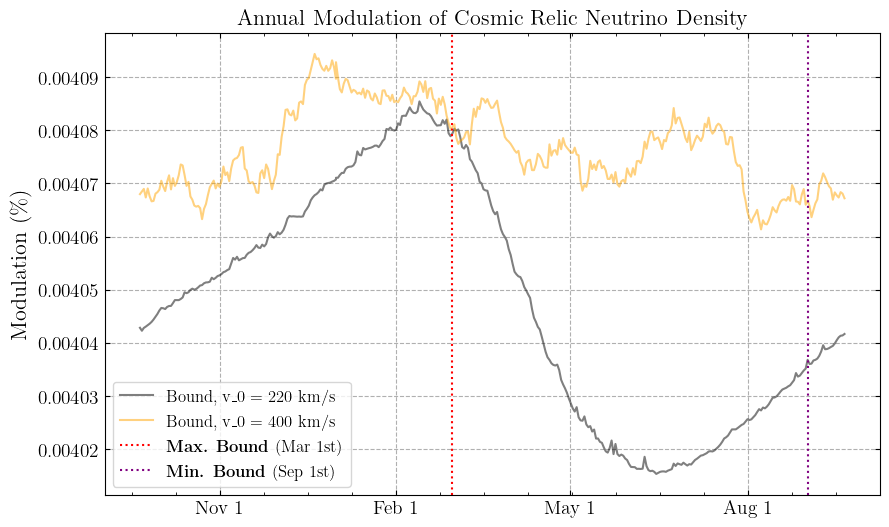

In [27]:
### ==================================== ###
### Get Earth's positions and velocities ###
### ==================================== ###

earth_positions = jnp.array(
    [pos for _, pos in calculate_earth_position(year)])*Params.AU
earth_velocities = jnp.array(
    [vel for _, vel in calculate_earth_velocity(year)])*Params.km/Params.s
print(earth_positions.shape, earth_velocities.shape)
# print(earth_positions[0], jnp.linalg.norm(earth_velocities[0]))

# Generate time points for one year
times = jnp.linspace(0, Params.yr, 365)
jd_times = Time('2023-01-01').jd + times / Params.yr * 365


# # Length of semi-major axis of Earth's orbit
# a = 1.4960e8*Params.km  # (almost equal to Params.AU)
# # ecc = 0.016722  # Eccentricity of Earth's orbit
# ecc = 0.9574*Params.deg
# # y_p = 102*Params.deg  # Ecliptic longitude of the perihelion as in 2013
# y_p = 102*Params.deg
# v_earth = 29.79*Params.km/Params.s  # Earth's average orbital speed
# omega = 2*Params.Pi/Params.yr  # Angular frequency of Earth's orbit
# t_ve = 79/365*Params.yr  # Time of vernal equinox (in fraction of 1 year)
# t_p = 4/365*Params.yr  # Time of perihelion (in fraction of 1 year)

# Sun's velocity in CNB(==CMB) frame
v_CNB = jnp.array([-0.0695, -0.662, 0.747])*369*Params.km/Params.s

# Approximate escape velocity for MW
v_esc_MW = 550*Params.km/Params.s

# Sun's velocity in Galactic frame
v_Sun = jnp.array([11, 232, 7])*Params.km/Params.s


@jax.jit
def v_infinity(v_s, r_s):
    """
    Calculate the initial Solar-frame velocity for particles, s.t. they have velocity v_s at Earth's location.
    """
    
    v_GM = 2*Params.G*Params.Msun/jnp.linalg.norm(r_s, axis=-1)
    v_inf2 = jnp.linalg.norm(v_s, axis=-1)**2 - v_GM
    v_inf = jnp.sqrt(jnp.maximum(0, v_inf2))
    # v_inf = jnp.sqrt(v_inf2)
    r_s_unit = r_s / jnp.linalg.norm(r_s, axis=-1)
    vr_s_dot = jnp.dot(v_s, r_s_unit)

    numer = v_inf2[..., None]*v_s + v_inf[..., None]*v_GM/2*r_s_unit - v_inf[..., None]*v_s*vr_s_dot[..., None]
    denom = v_inf2 + v_GM/2 - v_inf*vr_s_dot
    
    return numer / denom[..., None]


@jax.jit
def f_distr(v_range, t_index, m_nu, bound, v_0):
    """Phase-space distribution at Earth's location."""

    # Get x,y,z coords.
    v_nu = Utils.v_mag_to_xyz(v_range, Params.key)

    # Compute v_inf and v argument as used for f(v)
    r_s = earth_positions[t_index]
    v_s = v_nu + earth_velocities[t_index]
    v_inf = v_infinity(v_s, r_s)

    def bound_case(_):

        v_for_f = v_inf + v_Sun
        v_for_f_mag = jnp.linalg.norm(v_for_f, axis=-1)

        # Create mask for velocity magnitudes smaller than escape velocity
        mask = v_for_f_mag < v_esc_MW

        # Compute standard halo model (SHM) distribution
        exp_term = jnp.exp(-v_for_f_mag**2/v_0**2)
        f_v = jnp.where(
            mask, 
            jnp.power(jnp.pi*v_0**2, -3/2) * exp_term, 
            jnp.zeros_like(exp_term))
        
        # Normalisation constant, and normalised velocity distribution
        z = v_esc_MW/v_0
        N_esc = jsp.special.erf(z) - 2/jnp.sqrt(jnp.pi)*z*jnp.exp(-z**2)
        f_v_normalized = f_v / N_esc

        return f_v_normalized

    def unbound_case(_):

        v_for_f = v_inf + v_CNB
        v_for_f_mag = jnp.linalg.norm(v_for_f, axis=-1)

        f_v = m_nu**3/(jnp.exp(m_nu*v_for_f_mag/Params.T_CNB)+1)

        return f_v

    f_v = jax.lax.cond(bound, bound_case, unbound_case, operand=None)

    return f_v

@jax.jit
def number_density(t_index, m_nu, bound, v_0):
    """Calculate the neutrino number density at time t (a certain day)."""

    # note: below reso of (0.001, 100, 100_000), curves are wonky
    p_range = jnp.geomspace(0.001, 100, 100_000) * Params.T_CNB
    v_range = p_range / m_nu

    def bound_case(_):
        
        f_v = f_distr(v_range, t_index, m_nu, bound, v_0)
        integrand = v_range**3 * f_v
        integral = trap(integrand, x=jnp.log(v_range), axis=-1)
        nu_dens_cm3 = integral/(2*jnp.pi**2)/Params.cm**-3
        return nu_dens_cm3

    def unbound_case(_):

        f_v = f_distr(v_range, t_index, m_nu, bound, v_0)
        integrand = v_range**3 * f_v
        integral = trap(integrand, x=jnp.log(v_range), axis=-1)
        nu_dens_cm3 = integral/(2*jnp.pi**2)/Params.cm**-3
        return nu_dens_cm3
    
    nu_dens = jax.lax.cond(bound, bound_case, unbound_case, operand=None)

    return nu_dens

@jax.jit
def calculate_modulation(m_nu, bound, v_0):
    """Calculate the fractional modulation throughout the year."""

    # nu_dens_fctn = lambda t_idx: number_density_3D(t_idx, m_nu, bound, v_0)
    nu_dens_fctn = lambda t_idx: number_density(t_idx, m_nu, bound, v_0)
    densities = jax.vmap(nu_dens_fctn)(jnp.arange(len(times)))

    min_density = jnp.min(densities)
    mod = (densities - min_density) / (densities + min_density) * 100

    # return times, mod
    return times, densities

def plot_modulations(which, start_date_str='09-11'):
    """Plot the fractional modulations for different scenarios."""
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()
    ax = fig.add_subplot(111)

    # Convert start_date_str to datetime object
    start_date = datetime.strptime(start_date_str, '%m-%d')
    
    # Calculate the day of the year for the start date
    start_day_of_year = start_date.timetuple().tm_yday

    m_nu_light = 0.15 * Params.eV
    m_nu_heavy = 0.35 * Params.eV
    
    cases = [
        (m_nu_light, False, 220*Params.km/Params.s, 'Unbound, 0.15 eV', 'dashed', 'purple', 0.5),
        (m_nu_heavy, False, 220*Params.km/Params.s, 'Unbound, 0.35 eV', 'dashed', 'blue', 0.5),
        (m_nu_heavy, True, 220*Params.km/Params.s, 'Bound, v_0 = 220 km/s', 'solid', 'black', 0.5),
        (m_nu_heavy, True, 400*Params.km/Params.s, 'Bound, v_0 = 400 km/s', 'solid', 'orange', 0.5)
    ]

    if which == "unbound":
        scenarios = cases[:2]
    elif which == "bound":
        scenarios = cases[2:]
    elif which == "both":
        scenarios = cases

    for m_nu, bound, v_0, label, linestyle, color, alpha in scenarios:
        days, mod = calculate_modulation(m_nu, bound, v_0)

        # Check if all elements are zero
        if jnp.all(mod == 0):
            print("all zeros")

        # Check if all elements are nan
        if jnp.all(jnp.isnan(mod)):
            print("all nan")

        # Shift days to start from the specified date
        shifted_days = (days/Params.yr*365 - start_day_of_year) % 365 + 1
        sorted_indices = jnp.argsort(shifted_days)
        shifted_days = shifted_days[sorted_indices]
        mod = mod[sorted_indices]

        ax.plot(
            shifted_days, mod, 
            linestyle=linestyle, color=color, label=label, alpha=alpha)

    # Calculate tick positions and labels
    tick_dates = [datetime_date(2000, 11, 1), datetime_date(2000, 2, 1), 
                datetime_date(2000, 5, 1), datetime_date(2000, 8, 1)]
    tick_days = [(d - datetime_date(2000, start_date.month, start_date.day)).days % 365 + 1 for d in tick_dates]

    tick_labels = ['Nov 1', 'Feb 1', 'May 1', 'Aug 1']

    plt.xticks(tick_days, tick_labels)

    # Set y-axis limits
    # plt.ylim(0, 3)

    plt.title('Annual Modulation of Cosmic Relic Neutrino Density')
    plt.ylabel(r'Modulation ($\%$)')
    plt.grid(True, which="major", linestyle="dashed")
    
    if which == "unbound" or which == "both":
        # Add vertical lines for ~March 12th and ~September 11th
        march_12 = (datetime_date(2000, 3, 12) - datetime_date(2000, start_date.month, start_date.day)).days % 365 + 1
        sept_11 = (datetime_date(2000, 9, 11) - datetime_date(2000, start_date.month, start_date.day)).days % 365 + 1

        plt.axvline(
            x=march_12, color='dodgerblue', linestyle=':', 
            label=r'$\textbf{Min. Unbound}$ (Mar 12th)')
        plt.axvline(
            x=sept_11, color='magenta', linestyle=':', 
            label=r'$\textbf{Max. Unbound}$ (Sep 11th)')
        
    elif which == "bound" or which == "both":
        # Add vertical lines for ~March 1st and ~September 1st
        march_1 = (datetime_date(2000, 3, 1) - datetime_date(2000, start_date.month, start_date.day)).days % 365 + 1
        sept_1 = (datetime_date(2000, 9, 1) - datetime_date(2000, start_date.month, start_date.day)).days % 365 + 1

        # Plot the vertical lines
        plt.axvline(
            x=march_1, color='red', linestyle=':', 
            label=r'$\textbf{Max. Bound}$ (Mar 1st)')
        plt.axvline(
            x=sept_1, color='purple', linestyle=':', 
            label=r'$\textbf{Min. Bound}$ (Sep 1st)')


    plt.legend(prop={"size":12})

    plt.savefig(
        f"modulation_1year_Earth_frame_{start_date_str}start_FD.pdf",
        bbox_inches="tight")

    plt.show()
    plt.close()

mesh_num = 50
# Run the function with a specific start date
# plot_modulations(which="unbound", start_date_str='09-20')
plot_modulations(which="bound", start_date_str='09-20')
# plot_modulations(which="both", start_date_str='09-20')

In [17]:
Params.N0_cm3

Array(56.60912165, dtype=float64)

## Maxwell velocity distr. (SMH) integrating to 1

In [ ]:
def maxwell_f(v_3D, v_0, v_esc):

    v_mag = jnp.linalg.norm(v_3D, axis=-1)

    mask = v_mag < v_esc
    f_v = jnp.where(
        mask, 
        jnp.power(jnp.pi*v_0**2, -3/2) * jnp.exp(-v_mag**2/v_0**2), 
        0.0)
    z = v_esc/v_0
    N_esc = jsp.special.erf(z) - 2/jnp.sqrt(jnp.pi)*z*jnp.exp(-z**2)
    f_v_normalized = f_v / N_esc

    return f_v_normalized

p_range = jnp.geomspace(0.01, 10, 1000)*Params.T_CNB
v_unit = Params.km/Params.s
v_range = p_range / 0.35
v_nu = Utils.v_mag_to_xyz(v_range, Params.key)

f_v_norm = maxwell_f(v_nu, 220*v_unit, 550*v_unit)
f_int = trap(v_range**3*f_v_norm, x=jnp.log(v_range))
print(4*jnp.pi*f_int)

## 1D (isotropic) integration of $f_{\rm FD}(\vec{v}_\nu)$

In [ ]:
m_nu = 0.35*Params.eV
p_range = jnp.geomspace(0.01, 10, 1000)*Params.T_CNB
v_range = p_range / m_nu


def fermi_dirac_mom(p):
    return 1/(jnp.exp(p/Params.T_CNB)+1)

f_FD_p = fermi_dirac_mom(p_range)
f_int_p = trap(p_range**3*f_FD_p, x=jnp.log(p_range))
print(f"1D number density (p): {f_int_p/(2*jnp.pi**2)/Params.cm**-3:5f} cm^-3")


def fermi_dirac_vel(m, v):
    return m**3/(jnp.exp(m*v/Params.T_CNB)+1)

f_FD_v = fermi_dirac_vel(m_nu, v_range)

f_int_v = trap(v_range**3*f_FD_v, x=jnp.log(v_range))
print(f"1D number density (v): {f_int_v/(2*jnp.pi**2)/Params.cm**-3:5f} cm^-3")

## 3D integration of $f_{\rm FD}(\vec{v}_\nu)$

In [ ]:
@jax.jit
def fermi_dirac_vel(m, v_x, v_y, v_z):
    v = jnp.sqrt(v_x**2 + v_y**2 + v_z**2)
    return m**3 / (jnp.exp(m*v/Params.T_CNB) + 1)

@jax.jit
def number_density_3d(m_nu, v_max):
    
    # We can use the (+/-) max velocity magnitudes to create the ranges for the 
    # x,y,z components, because accounting for the whole velocity sphere means 
    # that the extremes would be that e.g. the x-direction has the total 
    # (+ or -) value of the magnitude already, whereas y-, and z- are 0. And so 
    # for all the other extreme cases. Then the mesh grid accounts for all 
    # x,y,z combinations.
    mesh_num = 500
    mesh_v = jnp.linspace(-v_max, v_max, mesh_num)
    v_x, v_y, v_z = jnp.meshgrid(mesh_v, mesh_v, mesh_v, indexing='xy')

    f_FD_v = fermi_dirac_vel(m_nu, v_x, v_y, v_z)
    print(f_FD_v.shape)

    # Perform the 3D integration
    integral_over_z = trap(f_FD_v, mesh_v, axis=-1)
    integral_over_yz = trap(integral_over_z, mesh_v, axis=-1)
    integral_over_xyz = trap(integral_over_yz, mesh_v, axis=-1)
    
    return integral_over_xyz / (2*jnp.pi)**3
    

# Parameters
m_nu = 0.35*Params.eV
v_max = 100*Params.T_CNB / m_nu

# Compute number density using 3D integration
n_3d = number_density_3d(m_nu, v_max)
print(f"3D number density: {n_3d/Params.cm**-3:5f} cm^-3")
n_3d /= Params.N0
print(f"normalised: {n_3d}")
#? so by density "rho" they actually mean the number density?

Adding any constant velocities here, as e.g. $f_{\rm FD}(\vec{v}_\nu + \vec{v}_{\rm CMB} + \vec{V}_\oplus(t))$, will technically not affect the number density, as the integration over each axis ideally goes from -inf to inf. So shifting the v_range will not affect anything. Of course that's hard to demonstrate numerically though, as it would require very large mesh range and dense sampling.

See cell below for attempt.

In [ ]:
@jax.jit
def fermi_dirac_vel(m, v_x, v_y, v_z):
    v = jnp.sqrt(v_x**2 + v_y**2 + v_z**2)
    return m**3 / (jnp.exp(m*v/Params.T_CNB) + 1)

@jax.jit
def number_density_3d(t_index, m_nu, v_max):

    mesh_num = 500
    mesh_v = jnp.linspace(-v_max, v_max, mesh_num)
    v_x, v_y, v_z = jnp.meshgrid(mesh_v, mesh_v, mesh_v, indexing='xy')

    # Add constant velocities
    v_x += v_CNB[0] + earth_velocities[t_index,0]
    v_y += v_CNB[1] + earth_velocities[t_index,1]
    v_z += v_CNB[2] + earth_velocities[t_index,2]

    f_FD_v = fermi_dirac_vel(m_nu, v_x, v_y, v_z)

    # Perform the 3D integration
    integral_over_z = trap(f_FD_v, mesh_v, axis=-1)
    integral_over_yz = trap(integral_over_z, mesh_v, axis=-1)
    integral_over_xyz = trap(integral_over_yz, mesh_v, axis=-1)
    
    return integral_over_xyz / (2*jnp.pi)**3
    

# Parameters
m_nu = 0.35*Params.eV
v_max = 100*Params.T_CNB / m_nu

# Compute number density using 3D integration
for t_index in (1, 45, 90, 135, 180, 225, 270):
    n_3d = number_density_3d(t_index, m_nu, v_max)
    print(f"3D n_nu (day {t_index}): {n_3d/Params.cm**-3:5f} cm^-3 (norm: {n_3d/Params.N0:6f})")

## Annual modulation: Single halo

In [ ]:
import datetime
def modulation_1halo(
        nu_dens_days, simulated_days, halo_i, start_date_str='09-11'):

    fig = plt.figure(figsize =(10, 6))
    fig.tight_layout()
    ax = fig.add_subplot(111)

    # Convert start_date_str to datetime object
    start_date = datetime.datetime.strptime(start_date_str, '%m-%d')
    
    # Calculate the day of the year for the start date
    start_day_of_year = start_date.timetuple().tm_yday

    # Shift days to start from the specified date
    shifted_days = (simulated_days - start_day_of_year) % 365 + 1
    sorted_indices = jnp.argsort(shifted_days)
    shifted_days = shifted_days[sorted_indices]

    # Adjust vertical lines for March 12th and September 11th
    march_12 = (datetime.date(2000, 3, 12) - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1
    sept_11 = (datetime.date(2000, 9, 11) - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1

    violet_colors = [
        "hotpink", 
        "mediumvioletred", 
        "blueviolet",
        "rebeccapurple",
    ]

    for m_idx, (m_val, color) in enumerate(zip(nu_m_picks[:4], violet_colors)):

        nu_dens_m = nu_dens_days[:, m_idx]

        # Compute fractional modulation
        nu_min = jnp.min(nu_dens_m)
        mod = (nu_dens_m - nu_min) / (nu_dens_m + nu_min) * 100
        mod = mod[sorted_indices]

        ax.plot(shifted_days, mod, 'o-', color=color, label=fr"$m_\nu = {m_val}$ eV")

    # Calculate tick positions and labels
    tick_dates = [datetime.date(2000, 11, 1), datetime.date(2000, 2, 1), 
                  datetime.date(2000, 5, 1), datetime.date(2000, 8, 1)]
    tick_days = [(date - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1 
                 for date in tick_dates]
    tick_labels = ['Nov 1', 'Feb 1', 'May 1', 'Aug 1']

    plt.xticks(tick_days, tick_labels)

    # Set x-axis limits
    # plt.xlim(1, 365)
    plt.ylim(0, 1)

    plt.title(f"Halo {halo_i+1}")
    plt.ylabel(r'Modulation ($\%$)')
    plt.grid(True, which="major", linestyle="dashed")

    plt.axvline(x=march_12, color='r', linestyle=':', label='March 12th')
    plt.axvline(x=sept_11, color='g', linestyle=':', label='September 11th')

    plt.legend(prop={"size":12})

    # plt.savefig(
    #     f"{fig_folder}/modulation_1year_Earth_frame_{start_date_str}start.pdf",
    #     bbox_inches="tight")
    plt.savefig(
        f"{fig_folder}/modulation_1year_Earth_frame_{start_date_str}start_FD.pdf",
        bbox_inches="tight")

    plt.show()
    plt.close()


# Load number densities and associated days arrays
# n_nu_days = jnp.load(f"{sim_folder}/n_nu_days_Earth_frame.npy")
# days_nrs = jnp.load(f"{sim_folder}/days_nrs_Earth_frame.npy")
# ic(n_nu_days.shape)

# for hi in (0,1,4,5):
#     modulation_1halo(
#         nu_dens_days=n_nu_days[:,hi,:]/Params.N0_cm3, 
#         simulated_days=days_nrs, halo_i=hi, start_date_str="09-11")


n_nu_days_FD = jnp.load(f"{sim_folder}/n_nu_days_Earth_frame_FD.npy")
days_nrs_FD = jnp.load(f"{sim_folder}/days_nrs_Earth_frame_FD.npy")
modulation_1halo(
    nu_dens_days=n_nu_days_FD[:,0,:]/Params.N0_cm3, halo_i=0,
    simulated_days=days_nrs_FD, start_date_str="09-11")

## Annual modulation: Halo band

In [ ]:
def modulation_band(nu_dens_days, simulated_days, nu_m_picks, start_date_str='09-11'):
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()
    ax = fig.add_subplot(111)

    # Convert start_date_str to datetime object
    start_date = datetime.datetime.strptime(start_date_str, '%m-%d')
    
    # Calculate the day of the year for the start date
    start_day_of_year = start_date.timetuple().tm_yday

    # Shift days to start from the specified date
    shifted_days = (simulated_days - start_day_of_year) % 365 + 1
    sorted_indices = jnp.argsort(shifted_days)
    shifted_days = shifted_days[sorted_indices]

    # Adjust vertical lines for March 12th and September 11th
    march_12 = (datetime.date(2000, 3, 12) - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1
    sept_11 = (datetime.date(2000, 9, 11) - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1

    violet_colors = [
        "hotpink", 
        "mediumvioletred", 
        "blueviolet",
        "rebeccapurple",
    ]

    for m_idx, (m_val, color) in enumerate(zip(nu_m_picks[:4], violet_colors)):
        nu_dens_m = nu_dens_days[:, :, m_idx]  # (days, halos)

        # Compute fractional modulation for each halo
        nu_min = jnp.min(nu_dens_m, axis=0)
        mod = (nu_dens_m - nu_min) / (nu_dens_m + nu_min) * 100

        # Sort modulation values for each day
        mod_sorted = jnp.sort(mod, axis=1)

        # Compute median and 1-sigma band
        median = jnp.median(mod_sorted, axis=1)
        lower = jnp.percentile(mod_sorted, 16, axis=1)
        upper = jnp.percentile(mod_sorted, 84, axis=1)

        # Apply sorting to match shifted_days
        median = median[sorted_indices]
        lower = lower[sorted_indices]
        upper = upper[sorted_indices]

        # Plot median and 1-sigma band
        ax.plot(shifted_days, median, '-', color=color, label=fr"$m_\nu = {m_val}$ eV")
        ax.fill_between(shifted_days, lower, upper, color=color, alpha=0.3)

    # Calculate tick positions and labels
    tick_dates = [datetime.date(2000, 11, 1), datetime.date(2000, 2, 1), 
                  datetime.date(2000, 5, 1), datetime.date(2000, 8, 1)]
    tick_days = [(date - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1 
                 for date in tick_dates]
    tick_labels = ['Nov 1', 'Feb 1', 'May 1', 'Aug 1']

    plt.xticks(tick_days, tick_labels)

    # Set axis limits and labels
    plt.ylim(0, 1)
    plt.ylabel(r'Modulation ($\%$)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True, which="major", linestyle="dashed")

    plt.axvline(x=march_12, color='r', linestyle=':', label='March 12th')
    plt.axvline(x=sept_11, color='g', linestyle=':', label='September 11th')

    plt.legend(prop={"size":12})

    plt.savefig(
        f"{fig_folder}/modulation_1year_Earth_frame_{start_date_str}start_band.pdf",
        bbox_inches="tight")

    plt.show()
    plt.close()

# Load number densities and associated days arrays
n_nu_days = jnp.load(f"{sim_folder}/n_nu_days_Earth_frame.npy")
days_nrs = jnp.load(f"{sim_folder}/days_nrs_Earth_frame.npy")
print(f"n_nu_days shape: {n_nu_days.shape}")

# Call the modulation function with the full n_nu_days array
modulation_band(
    nu_dens_days=n_nu_days/Params.N0_cm3, 
    simulated_days=days_nrs, 
    nu_m_picks=nu_m_picks,
    start_date_str="09-11")